# Setup

In [1]:
print('Installing torchquantum...')
!git clone -b isca https://github.com/mit-han-lab/torchquantum.git
%cd /content/torchquantum
!pip install --editable . 1>/dev/null
# print('All required packages have been successfully installed!')

Installing torchquantum...
Cloning into 'torchquantum'...
remote: Enumerating objects: 11836, done.
remote: Counting objects: 100% (726/726), done.
remote: Compressing objects: 100% (306/306), done.
remote: Total 11836 (delta 435), reused 685 (delta 405), pack-reused 11110
Receiving objects: 100% (11836/11836), 33.59 MiB | 23.82 MiB/s, done.
Resolving deltas: 100% (6592/6592), done.
/content/torchquantum


In [2]:
!pip install tensorflow_model_optimization . 1>/dev/null
!ls artifact
!cp artifact/aerbackend.py ../../usr/local/lib/python3.7/dist-packages/qiskit/providers/aer/backends/ -r
!wget https://www.dropbox.com/s/pvoqeab2z2cazke/max-acc-valid.pt
!pip install matplotlib==3.1.3 1>/dev/null
%matplotlib inline

  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
aerbackend.py  example2  example4  example6  README.md
example1       example3  example5  example7
--2022-09-19 15:33:01--  https://www.dropbox.com/s/pvoqeab2z2cazke/max-acc-valid.pt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/pvoqeab2z2cazke/max-acc-valid.pt [following]
--2022-09-19 15:33:01--  https://www.dropbox.com/s/raw/pvoqeab2z2cazke/max-acc-valid.pt
Reusing existing connection to www.dropbox.com:443.
H

In [6]:
!wget https://www.dropbox.com/s/pvoqeab2z2cazke/max-acc-valid.pt

--2023-06-17 18:11:00--  https://www.dropbox.com/s/pvoqeab2z2cazke/max-acc-valid.pt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.4.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.4.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/pvoqeab2z2cazke/max-acc-valid.pt [following]
--2023-06-17 18:11:00--  https://www.dropbox.com/s/raw/pvoqeab2z2cazke/max-acc-valid.pt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc955ee3fe3d5f662b1900a4a544.dl.dropboxusercontent.com/cd/0/inline/B-LVqVeDlWYn6MPQj4VMFWuU_GApghKOP2rpQp8W9vuQo_Y37Snlgwoihxsn_F01Wsi5vqEd_71PnfCjFgTlV5Zv47OGkkyog35uDfYHRi3ckHhHkzFAYbBX9c_FKqLScylLJ0ByUFtWK_NR36neHqtLMne4c5zBatA1znoNMw1kvA/file# [following]
--2023-06-17 18:11:01--  https://uc955ee3fe3d5f662b1900a4a544.dl.dropboxusercontent.com/cd/0/inline/B-LVqVeDlWYn6MPQj4VMFWuU_GApghKOP2rpQp8W9vuQo_Y37Snlgwoihxsn_F01Wsi5

In [5]:
import argparse
import os
import sys
import pdb
import numpy as np
import torch
import torch.backends.cudnn
import torch.cuda
import torch.nn
import torch.utils.data
import torchquantum as tq
import tqdm
import random

from torchpack.utils import io
# from torchpack import distributed as dist
from torchpack.environ import set_run_dir
from torchpack.utils.config import configs
from torchpack.utils.logging import logger
from torchquantum.datasets import MNIST
import torch.optim as optim

from torchquantum.plugins import tq2qiskit, qiskit2tq
from torchquantum.utils import (build_module_from_op_list,
                                build_module_op_list,
                                get_v_c_reg_mapping,
                                get_p_c_reg_mapping,
                                get_p_v_reg_mapping,
                                get_cared_configs)
from torchquantum.super_utils import get_named_sample_arch
from torch.utils.tensorboard import SummaryWriter

# **2. Usa TorchQuantum on the gate level**

## 2.1 QuantumNAS: Circuit Search and Pruning

 **Goals**

In this sectio you will practice searching an optimal subcircuit from a supercircuit and pruning the searched subcircuit to reduce the impact of noise and improve accuracy on real Quantum Computer. The goals of this assignment are as follows:

- Understand the basic concept of **supercircuit** and **subcircuit**
- Implement and apply **Evolutionary Search**
- Implement and apply **Pruning**
- Get a basic understanding of performance improvement (such as accuracy) from **Evolutionary Search** and **Pruning**

In [6]:
import torch
import torchquantum as tq
import torchquantum.functional as tqf
import torch.nn.functional as F

from torchpack.utils.logging import logger
from torchquantum.encoding import encoder_op_list_name_dict
from torchquantum.super_layers import super_layer_name_dict

from torchquantum.plugins import (
    tq2qiskit_measurement,
    qiskit_assemble_circs,
    op_history2qiskit,
    op_history2qiskit_expand_params,
)

class SuperQFCModel0(tq.QuantumModule):
    def __init__(self, arch):
        super().__init__()
        self.arch = arch
        self.n_wires = arch['n_wires']
        # self.q_device = tq.QuantumDevice(n_wires=self.n_wires)
        self.encoder = tq.GeneralEncoder(
            encoder_op_list_name_dict[arch['encoder_op_list_name']]
        )
        self.q_layer = super_layer_name_dict[arch['q_layer_name']](arch)
        self.measure = tq.MeasureAll(tq.PauliZ)
        self.sample_arch = None

    def set_sample_arch(self, sample_arch):
        self.sample_arch = sample_arch
        self.q_layer.set_sample_arch(sample_arch)

    def count_sample_params(self):
        return self.q_layer.count_sample_params()

    def forward(self, x, verbose=False, use_qiskit=False):
        bsz = x.shape[0]
        qdev = tq.QuantumDevice(n_wires=self.n_wires, bsz=bsz, record_op=True, device=x.device)
        # self.q_device.reset_states(bsz=bsz)

        if getattr(self.arch, 'down_sample_kernel_size', None) is not None:
            x = F.avg_pool2d(x, self.arch['down_sample_kernel_size'])

        x = x.view(bsz, -1)

        if use_qiskit:
            # use qiskit to process the circuit
            # create the qiskit circuit for encoder
            self.encoder(qdev, x)  
            op_history_parameterized = qdev.op_history
            qdev.reset_op_history()
            encoder_circs = op_history2qiskit_expand_params(self.n_wires, op_history_parameterized, bsz=bsz)

            # create the qiskit circuit for trainable quantum layers
            self.q_layer(qdev)
            op_history_fixed = qdev.op_history
            qdev.reset_op_history()
            q_layer_circ = op_history2qiskit(self.n_wires, op_history_fixed)

            # create the qiskit circuit for measurement
            measurement_circ = tq2qiskit_measurement(qdev, self.measure)

            # assemble the encoder, trainable quantum layers, and measurement circuits
            assembled_circs = qiskit_assemble_circs(
                encoder_circs, q_layer_circ, measurement_circ
            )

            # call the qiskit processor to process the circuit
            x0 = self.qiskit_processor.process_ready_circs(qdev, assembled_circs).to(  # type: ignore
                x.device
            )
            x = x0

            # x = self.qiskit_processor.process_parameterized(
                # self.q_device, self.encoder, self.q_layer, self.measure, x)
        else:
            self.encoder(qdev, x)
            self.q_layer(qdev)
            x = self.measure(qdev)

        if verbose:
            logger.info(f"[use_qiskit]={use_qiskit}, expectation:\n {x.data}")

        if getattr(self.arch, 'output_len', None) is not None:
            x = x.reshape(bsz, -1, self.arch.output_len).sum(-1)

        if x.dim() > 2:
            x = x.squeeze()

        x = F.log_softmax(x, dim=1)
        return x

    @property
    def arch_space(self):
        space = []
        for layer in self.q_layer.super_layers_all:
            space.append(layer.arch_space)
        # for the number of sampled blocks
        space.append(list(range(self.q_layer.n_front_share_blocks,
                                self.q_layer.n_blocks + 1)))
        return space


**Load configs**

The config file describes everything about the model structure.

In [7]:
config_str = '''model:
  arch:
    n_wires: 4
    encoder_op_list_name: 4x4_ryzxy
    n_blocks: 3
    n_layers_per_block: 2
    q_layer_name: u3cu3_s0
    down_sample_kernel_size: 6
    n_front_share_blocks: 1
    n_front_share_wires: 1
    n_front_share_ops: 1
  sampler:
    strategy:
      name: plain
  transpile_before_run: False
  load_op_list: False

dataset:
  name: mnist
  input_name: image
  target_name: digit

optimizer:
  name: adam
  lr: 5e-2
  weight_decay: 1e-4
  lambda_lr: 1e-2

run:
  n_epochs: 40
  bsz: 256
  workers_per_gpu: 2
  device: gpu

debug:
  pdb: False
  set_seed: True
  seed: 42

callbacks:
  - callback: 'InferenceRunner'
    split: 'valid'
    subcallbacks:
      - metrics: 'CategoricalAccuracy'
        name: 'acc/valid'
      - metrics: 'NLLError'
        name: 'loss/valid'
  - callback: 'InferenceRunner'
    split: 'test'
    subcallbacks:
      - metrics: 'CategoricalAccuracy'
        name: 'acc/test'
      - metrics: 'NLLError'
        name: 'loss/test'
  - callback: 'MaxSaver'
    name: 'acc/valid'
  - callback: 'Saver'
    max_to_keep: 10

qiskit:
  use_qiskit: False
  use_real_qc: False
  backend_name: null
  noise_model_name: null
  basis_gates_name: null
  n_shots: 8192
  initial_layout: null
  seed_transpiler: 42
  seed_simulator: 42
  optimization_level: 0
  est_success_rate: False
  max_jobs: 1


es:
  random_search: False
  population_size: 100
  parent_size: 20
  mutation_size: 40
  mutation_prob: 0.5
  crossover_size: 40
  n_iterations: 5
  est_success_rate: False
  score_mode: loss_succ
  gene_mask: null
  eval:
    use_noise_model: False
    use_real_qc: False
    bsz: qiskit_max
    n_test_samples: 150


prune:
  target_pruning_amount : 0.5
  init_pruning_amount : 0.1
  start_epoch : 0
  end_epoch : 30

'''
f = open("configs.yml", "w")
f.write(config_str)
f.close()

In [8]:
configs.load('configs.yml')
if configs.debug.set_seed:
    torch.manual_seed(configs.debug.seed)
    np.random.seed(configs.debug.seed)

Load the model.

In [9]:
device = torch.device('cuda')
if isinstance(configs.optimizer.lr, str):
    configs.optimizer.lr = eval(configs.optimizer.lr)
dataset = MNIST(
    root='./mnist_data',
    train_valid_split_ratio=[0.9, 0.1],
    digits_of_interest=[0, 1, 2, 3],
    n_test_samples=300,
    n_train_samples=5000,
    n_valid_samples=3000,
)
dataflow = dict()
for split in dataset:
    sampler = torch.utils.data.RandomSampler(dataset[split])
    dataflow[split] = torch.utils.data.DataLoader(
        dataset[split],
        batch_size=configs.run.bsz,
        sampler=sampler,
        num_workers=configs.run.workers_per_gpu,
        pin_memory=True)
model = SuperQFCModel0(configs.model.arch)
state_dict = io.load('max-acc-valid.pt', map_location='cpu')
model.load_state_dict(state_dict['model'], strict=False)
model.to(device)
model.set_sample_arch([4,4,4,4,4,4,3])
total_params = sum(p.numel() for p in model.parameters())
logger.info(f'Model Size: {total_params}')

def log_acc(output_all, target_all, k=1):
    _, indices = output_all.topk(k, dim=1)
    masks = indices.eq(target_all.view(-1, 1).expand_as(indices))
    size = target_all.shape[0]
    corrects = masks.sum().item()
    accuracy = corrects / size
    loss = F.nll_loss(output_all, target_all).item()
    logger.info(f"Accuracy: {accuracy}")
    logger.info(f"Loss: {loss}")
    return accuracy

def evaluate_gene(gene=None, use_qiskit=False):
    if gene is not None:
        model.set_sample_arch(gene)
    with torch.no_grad():
        target_all = None
        output_all = None
        for feed_dict in tqdm.tqdm(dataflow['test']):
            if configs.run.device == 'gpu':
                # pdb.set_trace()
                inputs = feed_dict[configs.dataset.input_name].cuda(non_blocking=True)
                targets = feed_dict[configs.dataset.target_name].cuda(non_blocking=True)
            else:
                inputs = feed_dict[configs.dataset.input_name]
                targets = feed_dict[configs.dataset.target_name]
            outputs = model(inputs, use_qiskit=use_qiskit)
            if target_all is None:
                target_all = targets
                output_all = outputs
            else:
                target_all = torch.cat([target_all, targets], dim=0)
                output_all = torch.cat([output_all, outputs], dim=0)
        accuracy = log_acc(output_all, target_all)
    return accuracy

[2023-06-18 11:29:59.898] Only use the front 5000 images as TRAIN set.
[2023-06-18 11:29:59.993] Only use the front 3000 images as VALID set.
[2023-06-18 11:30:00.048] Only use the front 300 images as TEST set.


[2023-06-18 11:30:01.772] Model Size: 72


**Let's use the model to predict MNIST images**

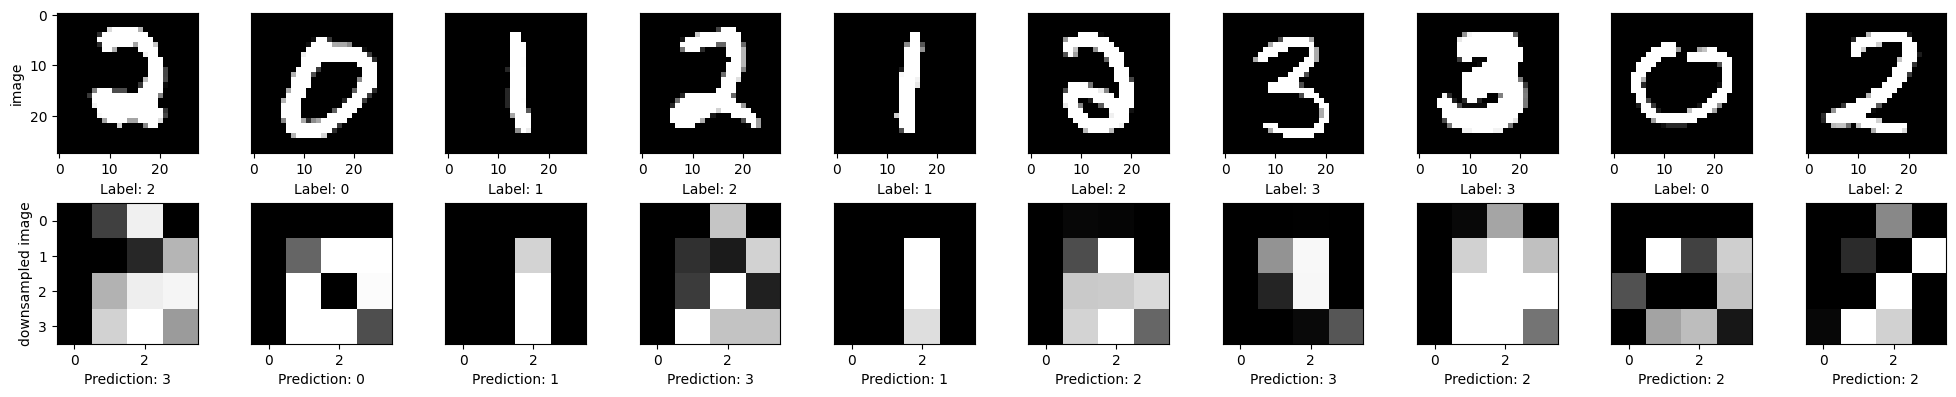

In [10]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
n_samples = 10
for feed_dict in dataflow['test']:
  inputs = feed_dict['image']
  outputs = feed_dict['digit']
  break
images = inputs[:n_samples]
# Down sample the image from 28x28 to 4x4.
# This down sampled image is the circuit input.
after_down_sample = F.avg_pool2d(images, 6)

# Forward the model to get prediction.
pred = model(images)
_, indices = pred.topk(1, dim=1)

# Plot 10 samples with label and prediction.
fig, axes = plt.subplots(2, n_samples, figsize=(20, 4))
for k in range(n_samples):
    axes[0, 0].set_ylabel("image")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].set_xlabel("Label: {0}".format(outputs[k]))
    norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
    axes[0, k].imshow(images[k, 0, :, :].cpu(), norm=norm, cmap="gray")

    axes[1, 0].set_ylabel("downsampled image")
    if k != 0:
        axes[1, k].yaxis.set_visible(False)
    axes[1, k].set_xlabel("Prediction: {0}".format(indices[k][0]))
    axes[1, k].imshow(after_down_sample[k, 0, :, :], norm=norm, cmap="gray")

plt.tight_layout()
plt.show()


**Supercircuit and  Subcircuit**

We constructed a SuperCircuit by stacking a sufficient number of layers of pre-defined parameterized gates to cover a large *design space*. Then, we have already trained the SuperCircuit by sampling and updating the parameter subsets (SubCircuits) from the SuperCircuit. The performance of a SubCircuit with inherited parameters from the SuperCircuit can provide a reliable relative performance estimation for the individual SubCircuit trained from scratch. In this way, we only pay the training cost once but can evaluate all the SubCircuits fast and efficiently. Hence, the search cost is significantly reduced. 

In this supercircuit, there are totally 3 blocks and 2 layers(a U3 layer and a CU3 layer) in each block. The gene (Which covers all *design space*) length is 7. The front 6 positions mean how many front gates we put in the circuit in kth layer. The last position of gene means how many front blocks we put in the circuit.


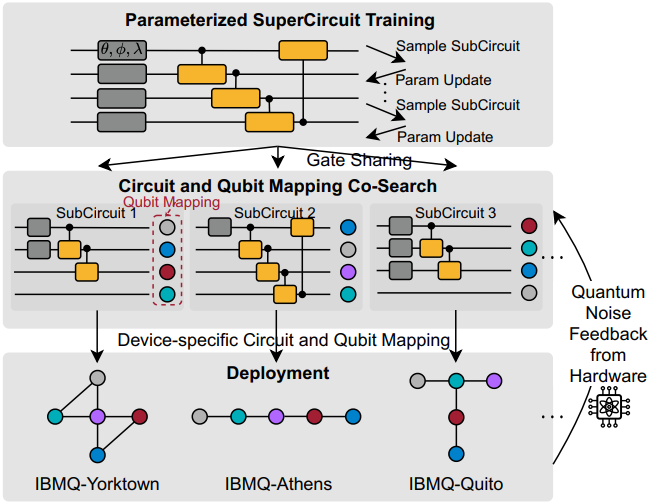


In the following code cell we randomly sample a subcircuit to further show the relation between the subcircuit's architecture and its gene for you to understand.


Sampled gene: [2, 2, 4, 2, 2, 1, 2]
Circuit depth: 6
Architecture:


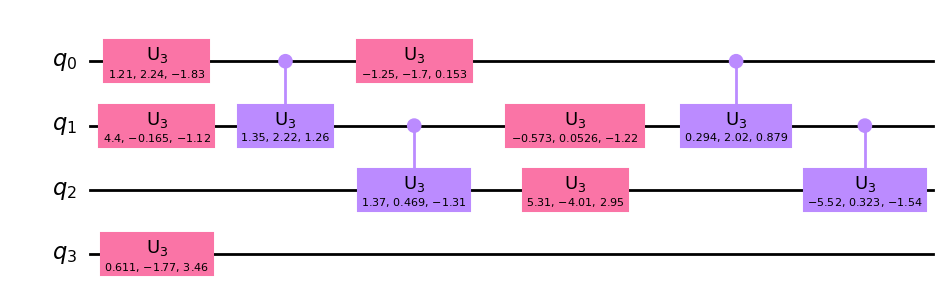

In [11]:
from torchquantum.plugins import tq2qiskit
gene_choice = model.arch_space
gene_len = len(gene_choice)
n_samples=1
samp_gene = []
for k in range(gene_len):
    samp_gene.append(random.choices(gene_choice[k])[0])
print("Sampled gene: " + str(samp_gene))
model.set_sample_arch(samp_gene)
circ = tq2qiskit(tq.QuantumDevice(n_wires=model.n_wires), model.q_layer)
print("Circuit depth: {0}".format(circ.depth()))
print("Architecture:")
circ.draw('mpl')

**Different performance between noise-free simulator and noisy simulator**
On real quantum computers, noise can distort the output of the circuit. In this subsection we will show the accuracy gap brought by noise. We use qiskit's noisy simulator to simulate the noisy environment on real quantum computers.

First, we setup a noisy simulator, **specify the *qubit mapping (layout)*** and attach it to our model.

In [12]:
from torchquantum.plugins import QiskitProcessor
from qiskit import IBMQ
IBMQ.save_account('', overwrite=True)

processor_real_qc = QiskitProcessor(use_real_qc=False, noise_model_name = 'ibmq_lima', backend_name='ibmq_lima')

processor_real_qc.set_layout([0, 1, 2, 3]) # default layout: virtual qubit 0 for physical qubit 0, ..., virtual qubit 3 for physical qubit 3

model.set_qiskit_processor(processor_real_qc)

Device reported a gate error parameter greater than maximum allowed value (1.000000 > 0.800000). Truncating to maximum value.
Device model returned a depolarizing error parameter greater than maximum allowed value (1.068463 > 1.066667). Truncating to maximum value.
Device reported a gate error parameter greater than maximum allowed value (1.000000 > 0.800000). Truncating to maximum value.
Device model returned a depolarizing error parameter greater than maximum allowed value (1.068596 > 1.066667). Truncating to maximum value.


100%|██████████| 2/2 [00:01<00:00,  1.61it/s]
[2023-06-18 02:14:39.511] Accuracy: 0.49666666666666665
[2023-06-18 02:14:39.513] Loss: 1.2080745697021484
  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 256/256 [00:04<00:00, 56.61it/s]


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


100%|██████████| 44/44 [00:00<00:00, 57.86it/s]


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


100%|██████████| 2/2 [00:18<00:00,  9.35s/it]
[2023-06-18 02:14:58.218] Accuracy: 0.5066666666666667
[2023-06-18 02:14:58.220] Loss: 1.2081890315281045
100%|██████████| 2/2 [00:00<00:00,  6.30it/s]
[2023-06-18 02:14:58.548] Accuracy: 0.5466666666666666
[2023-06-18 02:14:58.550] Loss: 1.107200026512146
100%|██████████| 256/256 [00:06<00:00, 39.42it/s]


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


100%|██████████| 44/44 [00:01<00:00, 42.01it/s]


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


100%|██████████| 2/2 [00:20<00:00, 10.06s/it]
[2023-06-18 02:15:18.681] Accuracy: 0.5466666666666666
[2023-06-18 02:15:18.682] Loss: 1.1146970560339424
100%|██████████| 2/2 [00:00<00:00,  6.20it/s]
[2023-06-18 02:15:19.011] Accuracy: 0.7133333333333334
[2023-06-18 02:15:19.012] Loss: 1.067213535308838
100%|██████████| 256/256 [00:07<00:00, 34.15it/s]


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


100%|██████████| 44/44 [00:01<00:00, 29.18it/s]


Job Status: job is actively runningn
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


100%|██████████| 2/2 [00:24<00:00, 12.19s/it]
[2023-06-18 02:15:43.397] Accuracy: 0.7133333333333334
[2023-06-18 02:15:43.398] Loss: 1.0787528759714957


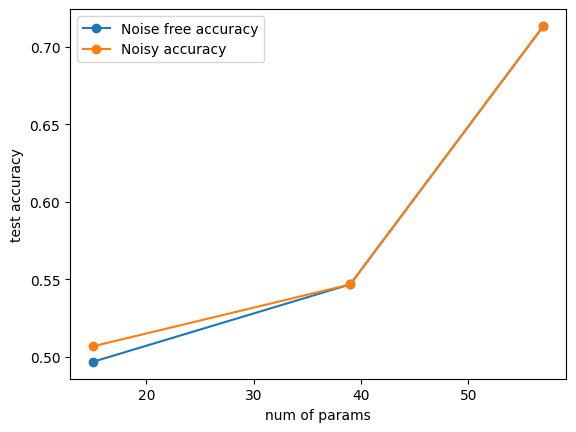

In [14]:
gene_list = [[3,2,4,4,2,4,1], [3,2,4,4,2,4,2], [3,2,4,4,2,4,3]]
param_num = []
accu_noise_free = []
accu_noisy_model = []
for gene in gene_list:
    total_params = 3 * sum(gene[k] for k in range(2 * gene[-1]))
    param_num.append(total_params)
    accu_noise_free.append(evaluate_gene(gene=gene, use_qiskit=False))
    accu_noisy_model.append(evaluate_gene(gene=gene, use_qiskit=True))

plt.plot(param_num, accu_noise_free, marker='o', label="Noise free accuracy")
plt.plot(param_num, accu_noisy_model, marker='o', label="Noisy accuracy")
plt.ylabel("test accuracy")
plt.xlabel("num of params")
plt.legend()
plt.show()

### Part 1: Search for the best gene

In order to find the best subcircuit in real quantum computer's noisy environment, we need the noisy simulator to search for the best gene.

####Part 1.1: Random Search



In [15]:
class RandomSearcher:
    def __init__(self, gene_choice, accuracy_predictor):
        self.gene_choice = gene_choice
        self.gene_len = len(self.gene_choice)
        self.accuracy_predictor = accuracy_predictor

    def random_sample(self, sample_num):
        # randomly sample genes
        population = []
        i = 0
        while i < sample_num:
            samp_gene = []
            for k in range(self.gene_len):
                samp_gene.append(random.choices(self.gene_choice[k])[0])
            population.append(samp_gene)
            i += 1

        return population

    def run_search(self, n_subcircuits=100):
        # sample subcircuits
        self.population = self.random_sample(n_subcircuits)
        # predict the accuracy of subnets
        accs = []
        for gene in self.population:
          accs.append(self.accuracy_predictor(gene=gene, use_qiskit=True))


        # get the index of the best subnet
        accs = np.array(accs)
        best_idx = accs.argmax()

        # return the best subnet
        return accs[best_idx], self.population[best_idx]

In [16]:
agent = RandomSearcher(model.arch_space, evaluate_gene)


# get the accuracy and gene of the best subcircuit
acc, gene = agent.run_search(10)

print(gene)
print(acc)

100%|██████████| 256/256 [00:05<00:00, 42.97it/s]


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


100%|██████████| 44/44 [00:00<00:00, 47.82it/s]


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


100%|██████████| 2/2 [00:20<00:00, 10.03s/it]
[2023-06-18 02:17:03.587] Accuracy: 0.5166666666666667
[2023-06-18 02:17:03.589] Loss: 1.1749059349133375
100%|██████████| 256/256 [00:05<00:00, 43.75it/s]


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


100%|██████████| 44/44 [00:00<00:00, 46.35it/s]


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


100%|██████████| 2/2 [00:19<00:00,  9.87s/it]
[2023-06-18 02:17:23.339] Accuracy: 0.55
[2023-06-18 02:17:23.341] Loss: 1.1280734676906572
100%|██████████| 256/256 [00:06<00:00, 40.20it/s]


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


100%|██████████| 44/44 [00:01<00:00, 38.82it/s]


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


100%|██████████| 2/2 [00:21<00:00, 10.82s/it]
[2023-06-18 02:17:44.984] Accuracy: 0.48
[2023-06-18 02:17:44.986] Loss: 1.1954604554205208
100%|██████████| 256/256 [00:04<00:00, 57.92it/s]


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


100%|██████████| 44/44 [00:00<00:00, 62.54it/s]


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


100%|██████████| 2/2 [00:18<00:00,  9.17s/it]
[2023-06-18 02:18:03.330] Accuracy: 0.4866666666666667
[2023-06-18 02:18:03.332] Loss: 1.221998074034077
100%|██████████| 256/256 [00:05<00:00, 44.04it/s]


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


100%|██████████| 44/44 [00:00<00:00, 44.96it/s]


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


100%|██████████| 2/2 [00:20<00:00, 10.34s/it]
[2023-06-18 02:18:24.018] Accuracy: 0.6166666666666667
[2023-06-18 02:18:24.019] Loss: 1.0832655545465577
100%|██████████| 256/256 [00:06<00:00, 38.08it/s]


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


100%|██████████| 44/44 [00:00<00:00, 44.45it/s]


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


100%|██████████| 2/2 [00:21<00:00, 10.64s/it]
[2023-06-18 02:18:45.313] Accuracy: 0.6266666666666667
[2023-06-18 02:18:45.315] Loss: 1.0833846881043825
100%|██████████| 256/256 [00:04<00:00, 59.31it/s]


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


100%|██████████| 44/44 [00:00<00:00, 48.29it/s]


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


100%|██████████| 2/2 [00:18<00:00,  9.17s/it]
[2023-06-18 02:19:03.663] Accuracy: 0.49666666666666665
[2023-06-18 02:19:03.665] Loss: 1.239231818450561
100%|██████████| 256/256 [00:04<00:00, 56.83it/s]


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


100%|██████████| 44/44 [00:00<00:00, 48.21it/s]


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


100%|██████████| 2/2 [00:18<00:00,  9.48s/it]
[2023-06-18 02:19:22.637] Accuracy: 0.4866666666666667
[2023-06-18 02:19:22.638] Loss: 1.2216246363067376
100%|██████████| 256/256 [00:05<00:00, 49.55it/s]


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


100%|██████████| 44/44 [00:01<00:00, 42.67it/s]


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


100%|██████████| 2/2 [00:19<00:00,  9.80s/it]
[2023-06-18 02:19:42.248] Accuracy: 0.58
[2023-06-18 02:19:42.249] Loss: 1.1266487995859988
100%|██████████| 256/256 [00:04<00:00, 55.45it/s]


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


100%|██████████| 44/44 [00:00<00:00, 52.88it/s]


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


100%|██████████| 2/2 [00:18<00:00,  9.36s/it]
[2023-06-18 02:20:00.973] Accuracy: 0.4
[2023-06-18 02:20:00.975] Loss: 1.2367691877893559


[3, 4, 2, 3, 1, 2, 3]
0.6266666666666667


####Part 1.2 Evolutionary Search


**Evolutionary Search**
In this part, we will implement a more sample-efficient search algorithm, evolutionary search. Evolutionary search is inspired by the evolution algorithm (or genetic algorithm). A **population** of sub-networks are first sampled from the design space. Then, in each **generation**, we perform random mutation and crossover operations as is shown in the figure above. The sub-networks with highest accuracy will be kept, and this process will be repeated until the number of generations reaches `max_time_budget`. Similar to the random search, throughout the search process, all sub-networks that cannot satisfy the efficiency constraint will be discarded.


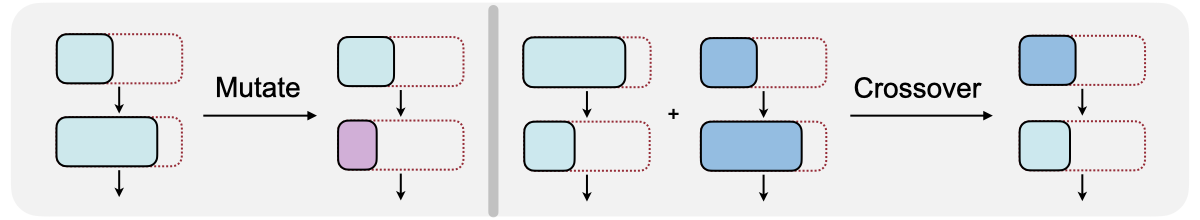

In [17]:
class EvolutionarySearcher:
    def __init__(self,
                 gene_choice,
                 accuracy_predictor,
                 configs):
        self.gene_choice = gene_choice
        self.gene_len = len(self.gene_choice)
        self.accuracy_predictor = accuracy_predictor
        self.n_iterations = configs.es.n_iterations
        self.parent_size = 2 #configs.es.parent_size
        self.mutation_size = 4 #configs.es.mutation_size
        self.mutation_prob = configs.es.mutation_prob
        self.crossover_size = 4 #configs.es.crossover_size

    def random_sample(self, sample_num):
        # randomly sample genes
        population = []
        i = 0
        while i < sample_num:
            samp_gene = []
            for k in range(self.gene_len):
                samp_gene.append(random.choices(self.gene_choice[k])[0])
            population.append(samp_gene)
            i += 1
        return population

    def ask(self):
        """return the solutions"""
        return self.population

    def select_and_transform(self, scores):
        """perform evo search according to the scores"""
        
        # sort the index according to the scores (descending order)
        sorted_idx = (-np.array(scores)).argsort()[:self.parent_size]

        # hint: update self.best_solution and self.best_score
        self.best_solution = self.population[sorted_idx[0]]
        self.best_score = scores[sorted_idx[0]]

        parents = [self.population[i] for i in sorted_idx]

        # mutation
        mutate_population = []
        k = 0
        while k < self.mutation_size:
            mutated_gene = self.mutate(random.choices(parents)[0])
            mutate_population.append(mutated_gene)
            k += 1

        # crossover
        crossover_population = []
        k = 0
        while k < self.crossover_size:
            crossovered_gene = self.crossover(random.sample(parents, 2))
            crossover_population.append(crossovered_gene)
            k += 1

        self.population = parents + mutate_population + crossover_population

    def crossover(self, genes):
        crossovered_gene = []
        for i in range(self.gene_len):
            if np.random.uniform() < 0.5:
                crossovered_gene.append(genes[0][i])
            else:
                crossovered_gene.append(genes[1][i])
        return crossovered_gene

    def mutate(self, gene):
        mutated_gene = []
        for i in range(self.gene_len):        
            # use np.random.uniform() to decide whether to mutate position i
            # mutate ith position of gene with self.mutation_prob as mutation probability
            if np.random.uniform() < self.mutation_prob:
                mutated_gene.append(random.choices(self.gene_choice[i])[0])
            else:
                mutated_gene.append(gene[i])
        return mutated_gene
    
    def run_search(self):
        # sample subcircuits
        self.population = self.random_sample(self.parent_size + self.mutation_size + self.crossover_size)
        for i in range(self.n_iterations):
            # predict the accuracy of subnets
            accs = []
            for gene in self.population:
                accs.append(self.accuracy_predictor(gene=gene, use_qiskit=True))
            self.select_and_transform(accs)
            logger.info(f"Best solution: {self.best_solution}")
            logger.info(f"Best score: {self.best_score}")
        # return the best subnet
        return self.best_score, self.best_solution

In [18]:
agent2 = EvolutionarySearcher(model.arch_space, evaluate_gene, configs)

# get the accuracy and gene of the best subcircuit
acc, gene = agent2.run_search()

print(gene)
print(acc)

100%|██████████| 256/256 [00:05<00:00, 45.04it/s]


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


100%|██████████| 44/44 [00:00<00:00, 45.01it/s]


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


100%|██████████| 2/2 [00:19<00:00,  9.81s/it]
[2023-06-18 02:23:23.397] Accuracy: 0.6466666666666666
[2023-06-18 02:23:23.398] Loss: 1.0970691853825159
100%|██████████| 256/256 [00:07<00:00, 35.76it/s]


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


100%|██████████| 44/44 [00:01<00:00, 40.32it/s]


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


100%|██████████| 2/2 [00:20<00:00, 10.39s/it]
[2023-06-18 02:23:44.178] Accuracy: 0.58
[2023-06-18 02:23:44.180] Loss: 1.0921902336146339
100%|██████████| 256/256 [00:07<00:00, 33.75it/s]


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


100%|██████████| 44/44 [00:01<00:00, 32.32it/s]


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


100%|██████████| 2/2 [00:23<00:00, 11.89s/it]
[2023-06-18 02:24:07.968] Accuracy: 0.47333333333333333
[2023-06-18 02:24:07.969] Loss: 1.1361960690479649
100%|██████████| 256/256 [00:06<00:00, 38.60it/s]


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


100%|██████████| 44/44 [00:01<00:00, 37.75it/s]


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


100%|██████████| 2/2 [00:21<00:00, 10.71s/it]
[2023-06-18 02:24:29.403] Accuracy: 0.47333333333333333
[2023-06-18 02:24:29.404] Loss: 1.2373305722974413
100%|██████████| 256/256 [00:08<00:00, 31.77it/s]


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job is actively runningn
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


100%|██████████| 44/44 [00:01<00:00, 29.61it/s]


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


100%|██████████| 2/2 [00:23<00:00, 11.67s/it]
[2023-06-18 02:24:52.757] Accuracy: 0.4766666666666667
[2023-06-18 02:24:52.759] Loss: 1.1376462017359017
100%|██████████| 256/256 [00:04<00:00, 61.27it/s]


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


100%|██████████| 44/44 [00:00<00:00, 55.57it/s]


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


100%|██████████| 2/2 [00:16<00:00,  8.47s/it]
[2023-06-18 02:25:09.717] Accuracy: 0.49666666666666665
[2023-06-18 02:25:09.719] Loss: 1.1492355493841508
100%|██████████| 256/256 [00:06<00:00, 38.31it/s]


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


100%|██████████| 44/44 [00:00<00:00, 44.26it/s]


Job Status: job is actively running

The searched best subcircui's architecture is this:

In [ ]:
model.set_sample_arch(gene)
circ = tq2qiskit(tq.QuantumDevice(n_wires=model.n_wires), model.q_layer)
print("Circuit depth: {0}".format(circ.depth()))
print("Gate counts: {0}".format(circ.count_ops()))
print("Architecture:")
circ.draw('mpl')

###Part 2: Prune the best subcircuit

Before pruning, we neeed to record the parameters for comparision with those after pruning.


In [24]:
def mod_pi(x):
    while x > np.pi:
        x = x - 2 * np.pi
    while x < -np.pi:
        x = x + 2 * np.pi
    return x

params_before_prune = []
for param in model.parameters():
    for x in param.reshape(-1):
        params_before_prune.append(mod_pi(x.cpu().detach().numpy()))

In [25]:
print(params_before_prune)

[array(1.2060113, dtype=float32), array(2.2385259, dtype=float32), array(-1.831825, dtype=float32), -1.8875616232501429, array(-0.16537467, dtype=float32), array(-1.1199452, dtype=float32), array(-3.0714889, dtype=float32), array(1.319183, dtype=float32), array(1.8012493, dtype=float32), array(-0.55449617, dtype=float32), -1.776839558278219, array(1.1050001, dtype=float32), array(1.3458017, dtype=float32), array(2.2216663, dtype=float32), array(1.2591805, dtype=float32), array(1.3722651, dtype=float32), array(0.46867403, dtype=float32), array(-1.3104833, dtype=float32), array(-2.6374984, dtype=float32), array(1.1927967, dtype=float32), array(-1.537862, dtype=float32), array(-0.961351, dtype=float32), array(-0.6752364, dtype=float32), array(0.6030566, dtype=float32), array(-1.2493807, dtype=float32), array(-1.7007474, dtype=float32), array(0.1528023, dtype=float32), array(-0.5733373, dtype=float32), array(0.05264929, dtype=float32), array(-1.218637, dtype=float32), -0.9736960569964808, 

Build the pruning trainer.

In [26]:
import torch.nn as nn
import torch.nn.utils.prune
from torchquantum.prune_utils import (PhaseL1UnstructuredPruningMethod,
                                      ThresholdScheduler)
from torchpack.train import Trainer
from torchpack.utils.typing import Optimizer, Scheduler
from torchpack.callbacks.writers import TFEventWriter
from typing import Any, Callable, Dict

class PruningTrainer(Trainer):
    """
    Perform pruning-aware training
    """
    def __init__(self, *, model: nn.Module, criterion: Callable,
                 optimizer: Optimizer, scheduler: Scheduler) -> None:
        self.model = model
        self.legalized_model = None
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.solution = None
        self.score = None

        self._parameters_to_prune = None
        self._target_pruning_amount = None
        self._init_pruning_amount = None
        self.prune_amount_scheduler = None
        self.prune_amount = None

        self.init_pruning()

    @staticmethod
    def extract_prunable_parameters(model: nn.Module) -> list:
        _parameters_to_prune = [
            (module, "params")
            for _, module in model.named_modules() if isinstance(module,
                                                                 tq.Operator)
            and module.params is not None]
        return _parameters_to_prune

    def init_pruning(self) -> None:
        """
        Initialize pruning procedure
        """
        self._parameters_to_prune = self.extract_prunable_parameters(
            self.model)
        self._target_pruning_amount = configs.prune.target_pruning_amount
        self._init_pruning_amount = configs.prune.init_pruning_amount
        self.prune_amount_scheduler = ThresholdScheduler(
            configs.prune.start_epoch, configs.prune.end_epoch,
            self._init_pruning_amount,
            self._target_pruning_amount)
        self.prune_amount = self._init_pruning_amount

    def _remove_pruning(self):
        for module, name in self._parameters_to_prune:
            nn.utils.prune.remove(module, name)

    def _prune_model(self, prune_amount) -> None:
        """
        Perform global threshold/percentage pruning on the quantum model.
        This function just performs pruning re-parametrization, i.e.,
        record weight_orig and generate weight_mask
        """
        # first clear current pruning container, since we do not want cascaded
        # pruning methods
        # remove operation will make pruning permanent
        if self.epoch_num > 1:
            self._remove_pruning()
        # perform global phase pruning based on the given pruning amount
        nn.utils.prune.global_unstructured(
            self._parameters_to_prune,
            pruning_method=PhaseL1UnstructuredPruningMethod,
            amount=prune_amount,
        )
        self.summary.add_scalar('prune_amount', prune_amount)

    def _before_epoch(self) -> None:
        self.model.train()

    def run_step(self, feed_dict: Dict[str, Any], legalize=False) -> Dict[str, Any]:
        output_dict = self._run_step(feed_dict, legalize=legalize)
        return output_dict

    def _run_step(self, feed_dict: Dict[str, Any], legalize=False) -> Dict[str, Any]:
        if configs.run.device == 'gpu':
            inputs = feed_dict[configs.dataset.input_name].cuda(
                non_blocking=True)
            targets = feed_dict[configs.dataset.target_name].cuda(
                non_blocking=True)
        else:
            inputs = feed_dict[configs.dataset.input_name]
            targets = feed_dict[configs.dataset.target_name]
        if legalize:
            outputs = self.legalized_model(inputs)
        else:
            outputs = self.model(inputs)
        loss = self.criterion(outputs, targets)
        nll_loss = loss.item()
        unitary_loss = 0

        if loss.requires_grad:
            for k, group in enumerate(self.optimizer.param_groups):
                self.summary.add_scalar(f'lr/lr_group{k}', group['lr'])

            self.summary.add_scalar('loss', loss.item())
            self.summary.add_scalar('nll_loss', nll_loss)
            if getattr(self.model, 'sample_arch', None) is not None:
                for writer in self.summary.writers:
                    if isinstance(writer, TFEventWriter):
                        writer.writer.add_text(
                            'sample_arch', str(self.model.sample_arch),
                            self.global_step)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        return {'outputs': outputs, 'targets': targets}

    def _after_epoch(self) -> None:
        self.model.eval()
        self.scheduler.step()
        # update pruning amount using the scheduler
        self.prune_amount = self.prune_amount_scheduler.step()
        # prune the model
        self._prune_model(self.prune_amount)
        # commit pruned parameters after training
        if self.epoch_num == self.num_epochs:
            self._remove_pruning()

    def _after_step(self, output_dict) -> None:
        pass

    def _state_dict(self) -> Dict[str, Any]:
        state_dict = dict()
        # need to store model arch because of randomness of random layers
        state_dict['model_arch'] = self.model
        state_dict['model'] = self.model.state_dict()
        state_dict['optimizer'] = self.optimizer.state_dict()
        state_dict['scheduler'] = self.scheduler.state_dict()
        if getattr(self.model, 'sample_arch', None) is not None:
            state_dict['sample_arch'] = self.model.sample_arch
        try:
            state_dict['q_layer_op_list'] = build_module_op_list(
                self.model.q_layer)
            state_dict['encoder_func_list'] = self.model.encoder.func_list
        except AttributeError:
            logger.warning(f"No q_layer_op_list or encoder_func_list found, "
                           f"will not save them")

        if self.solution is not None:
            state_dict['solution'] = self.solution
            state_dict['score'] = self.score

        try:
            state_dict['v_c_reg_mapping'] = self.model.measure.v_c_reg_mapping
        except AttributeError:
            logger.warning(f"No v_c_reg_mapping found, will not save it.")
        return state_dict

    def _load_state_dict(self, state_dict: Dict[str, Any]) -> None:
        # self.model.load_state_dict(state_dict['model'])
        self.optimizer.load_state_dict(state_dict['optimizer'])
        self.scheduler.load_state_dict(state_dict['scheduler'])


Some callbacks function useful for pruning.

In [27]:
from torchpack.callbacks import (InferenceRunner, MaxSaver, Saver, CategoricalAccuracy)
from examples.gradient_pruning.callbacks import NLLError

def get_subcallbacks(config):
    subcallbacks = []
    for subcallback in config:
        if subcallback['metrics'] == 'CategoricalAccuracy':
            subcallbacks.append(
                CategoricalAccuracy(name=subcallback['name'])
            )
        elif subcallback['metrics'] == 'NLLError':
            subcallbacks.append(
                NLLError(name=subcallback['name'])
            )
        else:
            raise NotImplementedError(subcallback['metrics'])
    return subcallbacks


def make_callbacks(dataflow):
    callbacks = []
    for config in configs['callbacks']:
        if config['callback'] == 'InferenceRunner':
            callback = InferenceRunner(
                dataflow=dataflow[config['split']],
                callbacks=get_subcallbacks(config['subcallbacks'])
            )
        elif config['callback'] == 'Saver':
            callback = Saver(max_to_keep=config['max_to_keep'])
        elif config['callback'] == 'MaxSaver':
            callback = MaxSaver(config['name'])
        else:
            raise NotImplementedError(config['callback'])
        callbacks.append(callback)

    return callbacks


You can set the pruning ratio on your own. If you have tried a pruning ratio and want to try another, simply change the pruning ratio and rerun the following codecell.

In [30]:
from torch.optim.lr_scheduler import CosineAnnealingLR

# Reset the pruning ratio here
configs.prune.target_pruning_amout = 0.5
n_finetune_epochs = 10

model2 = SuperQFCModel0(configs.model.arch)
state_dict = io.load('max-acc-valid.pt', map_location='cpu')
model2.load_state_dict(state_dict['model'], strict=False)
model2.to(device)
model2.set_sample_arch(gene)


if isinstance(configs.optimizer.lr, str):
    configs.optimizer.lr = eval(configs.optimizer.lr)
if isinstance(configs.optimizer.weight_decay, str):
    configs.optimizer.weight_decay = eval(configs.optimizer.weight_decay)
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(
    model2.parameters(),
    lr=configs.optimizer.lr,
    weight_decay=configs.optimizer.weight_decay)
scheduler = CosineAnnealingLR(optimizer, T_max=configs.run.n_epochs)
trainer = PruningTrainer(model=model2,
                    criterion=criterion,
                    optimizer=optimizer,
                    scheduler=scheduler)
run_dir = 'runs/quantumnas/'
set_run_dir(run_dir)
logger.info(' '.join([sys.executable] + sys.argv))
logger.info(f'Pruning started: "{run_dir}".' + '\n' +f'{configs}')
callbacks = make_callbacks(dataflow)
trainer.train_with_defaults(
    dataflow['train'],
    num_epochs=n_finetune_epochs,
    callbacks=callbacks)


[2022-09-19 00:55:30.977] /usr/bin/python3 /usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py -f /root/.local/share/jupyter/runtime/kernel-70920978-dd9d-487a-878a-8181130f4ed5.json
[2022-09-19 00:55:30.981] Pruning started: "runs/quantumnas/".
model:
  arch:
    n_wires: 4
    encoder_op_list_name: 4x4_ryzxy
    n_blocks: 3
    n_layers_per_block: 2
    q_layer_name: u3cu3_s0
    down_sample_kernel_size: 6
    n_front_share_blocks: 1
    n_front_share_wires: 1
    n_front_share_ops: 1
  sampler:
    strategy:
      name: plain
  transpile_before_run: False
  load_op_list: False
dataset:
  name: mnist
  input_name: image
  target_name: digit
optimizer:
  name: adam
  lr: 0.05
  weight_decay: 0.0001
  lambda_lr: 1e-2
run:
  n_epochs: 40
  bsz: 256
  workers_per_gpu: 2
  device: gpu
debug:
  pdb: False
  set_seed: True
  seed: 42
callbacks: [{'callback': 'InferenceRunner', 'split': 'valid', 'subcallbacks': [{'metrics': 'CategoricalAccuracy', 'name': 'acc/valid'}, {'metrics': 'NL

  0% 0/20 [00:00<?, ?it/s]

[2022-09-19 00:55:34.863] Training finished in 3.67 seconds.


  0% 0/10 [00:00<?, ?it/s]

[2022-09-19 00:55:36.312] Inference finished in 1.44 seconds.


  0% 0/2 [00:00<?, ?it/s]

[2022-09-19 00:55:36.831] Inference finished in 0.51 second.
[2022-09-19 00:55:56.905] Checkpoint saved: "runs/quantumnas/checkpoints/max-acc-valid.pt" (67.084).
[2022-09-19 00:55:56.951] Checkpoint saved: "runs/quantumnas/checkpoints/step-20.pt".
[2022-09-19 00:55:56.954] 
+ [acc/test] = 67.333
+ [acc/valid] = 67.084
+ [acc/valid/max] = 67.084
+ [loss] = 0.96537
+ [loss/test] = 0.99263
+ [loss/valid] = 0.99843
+ [lr/lr_group0] = 0.05
+ [nll_loss] = 0.96537
+ [prune_amount] = 0.1
[2022-09-19 00:55:56.957] Estimated time left: 3 minutes 51 seconds.
[2022-09-19 00:55:56.960] Epoch finished in 25.8 seconds.
[2022-09-19 00:55:56.962] Epoch 2/10 started.


  0% 0/20 [00:00<?, ?it/s]

[2022-09-19 00:55:59.503] Training finished in 2.54 seconds.


  0% 0/10 [00:00<?, ?it/s]

[2022-09-19 00:56:00.998] Inference finished in 1.49 seconds.


  0% 0/2 [00:00<?, ?it/s]

[2022-09-19 00:56:01.538] Inference finished in 0.53 second.
[2022-09-19 00:56:01.571] Checkpoint saved: "runs/quantumnas/checkpoints/max-acc-valid.pt" (68.659).
[2022-09-19 00:56:01.591] Checkpoint saved: "runs/quantumnas/checkpoints/step-40.pt".
[2022-09-19 00:56:01.592] 
+ [acc/test] = 67.333
+ [acc/valid] = 68.659
+ [acc/valid/max] = 68.659
+ [loss] = 0.997
+ [loss/test] = 0.97
+ [loss/valid] = 0.9794
+ [lr/lr_group0] = 0.049923
+ [nll_loss] = 0.997
+ [prune_amount] = 0.13868
[2022-09-19 00:56:01.597] Estimated time left: 2 minutes 1 second.
[2022-09-19 00:56:01.602] Epoch finished in 4.64 seconds.
[2022-09-19 00:56:01.603] Epoch 3/10 started.


  0% 0/20 [00:00<?, ?it/s]

[2022-09-19 00:56:04.207] Training finished in 2.6 seconds.


  0% 0/10 [00:00<?, ?it/s]

[2022-09-19 00:56:05.674] Inference finished in 1.46 seconds.


  0% 0/2 [00:00<?, ?it/s]

[2022-09-19 00:56:06.198] Inference finished in 0.517 second.
[2022-09-19 00:56:06.230] Checkpoint saved: "runs/quantumnas/checkpoints/step-60.pt".
[2022-09-19 00:56:06.232] 
+ [acc/test] = 65.667
+ [acc/valid] = 67.447
+ [acc/valid/max] = 68.659
+ [loss] = 1.0032
+ [loss/test] = 0.98233
+ [loss/valid] = 0.98394
+ [lr/lr_group0] = 0.049692
+ [nll_loss] = 1.0032
+ [prune_amount] = 0.17479
[2022-09-19 00:56:06.235] Estimated time left: 1 minute 21 seconds.
[2022-09-19 00:56:06.238] Epoch finished in 4.63 seconds.
[2022-09-19 00:56:06.241] Epoch 4/10 started.


  0% 0/20 [00:00<?, ?it/s]

[2022-09-19 00:56:08.745] Training finished in 2.5 seconds.


  0% 0/10 [00:00<?, ?it/s]

[2022-09-19 00:56:10.250] Inference finished in 1.5 seconds.


  0% 0/2 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9f0bb9f320>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9f0bb9f320>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

  0% 0/20 [00:00<?, ?it/s]

[2022-09-19 00:56:24.062] Training finished in 2.55 seconds.


  0% 0/10 [00:00<?, ?it/s]

[2022-09-19 00:56:25.570] Inference finished in 1.5 seconds.


  0% 0/2 [00:00<?, ?it/s]

[2022-09-19 00:56:26.122] Inference finished in 0.538 second.
[2022-09-19 00:56:26.153] Checkpoint saved: "runs/quantumnas/checkpoints/step-100.pt".
[2022-09-19 00:56:26.155] 
+ [acc/test] = 68
+ [acc/valid] = 68.215
+ [acc/valid/max] = 68.78
+ [loss] = 1.0229
+ [loss/test] = 0.96918
+ [loss/valid] = 0.97377
+ [lr/lr_group0] = 0.048776
+ [nll_loss] = 1.0229
+ [prune_amount] = 0.23961
[2022-09-19 00:56:26.157] Estimated time left: 55 seconds.
[2022-09-19 00:56:26.160] Epoch finished in 4.65 seconds.
[2022-09-19 00:56:26.162] Epoch 6/10 started.


  0% 0/20 [00:00<?, ?it/s]

[2022-09-19 00:56:28.735] Training finished in 2.57 seconds.


  0% 0/10 [00:00<?, ?it/s]

[2022-09-19 00:56:30.284] Inference finished in 1.55 seconds.


  0% 0/2 [00:00<?, ?it/s]

[2022-09-19 00:56:30.817] Inference finished in 0.529 second.
[2022-09-19 00:56:30.849] Checkpoint saved: "runs/quantumnas/checkpoints/max-acc-valid.pt" (69.225).
[2022-09-19 00:57:10.946] Checkpoint saved: "runs/quantumnas/checkpoints/step-120.pt".
[2022-09-19 00:57:10.961] 
+ [acc/test] = 67.667
+ [acc/valid] = 69.225
+ [acc/valid/max] = 69.225
+ [loss] = 0.99482
+ [loss/test] = 0.96391
+ [loss/valid] = 0.97313
+ [lr/lr_group0] = 0.048097
+ [nll_loss] = 0.99482
+ [prune_amount] = 0.26852
[2022-09-19 00:57:10.967] Estimated time left: 1 minute 6 seconds.
[2022-09-19 00:57:10.972] Epoch finished in 44.8 seconds.
[2022-09-19 00:57:10.977] Epoch 7/10 started.


  0% 0/20 [00:00<?, ?it/s]

[2022-09-19 00:57:13.609] Training finished in 2.63 seconds.


  0% 0/10 [00:00<?, ?it/s]

[2022-09-19 00:57:15.208] Inference finished in 1.6 seconds.


  0% 0/2 [00:00<?, ?it/s]

[2022-09-19 00:57:15.767] Inference finished in 0.549 second.
[2022-09-19 00:57:25.846] Checkpoint saved: "runs/quantumnas/checkpoints/step-140.pt".
[2022-09-19 00:57:25.849] 
+ [acc/test] = 66
+ [acc/valid] = 68.821
+ [acc/valid/max] = 69.225
+ [loss] = 0.94251
+ [loss/test] = 0.96686
+ [loss/valid] = 0.97313
+ [lr/lr_group0] = 0.047275
+ [nll_loss] = 0.94251
+ [prune_amount] = 0.2952
[2022-09-19 00:57:25.856] Estimated time left: 49.1 seconds.
[2022-09-19 00:57:25.860] Epoch finished in 14.9 seconds.
[2022-09-19 00:57:25.864] Epoch 8/10 started.


  0% 0/20 [00:00<?, ?it/s]

[2022-09-19 00:57:28.479] Training finished in 2.61 seconds.


  0% 0/10 [00:00<?, ?it/s]

[2022-09-19 00:57:30.010] Inference finished in 1.53 seconds.


  0% 0/2 [00:00<?, ?it/s]

[2022-09-19 00:57:30.595] Inference finished in 0.58 second.
[2022-09-19 00:57:30.630] Checkpoint saved: "runs/quantumnas/checkpoints/step-160.pt".
[2022-09-19 00:57:30.633] 
+ [acc/test] = 69
+ [acc/valid] = 66.721
+ [acc/valid/max] = 69.225
+ [loss] = 1.0047
+ [loss/test] = 0.99141
+ [loss/valid] = 1.0062
+ [lr/lr_group0] = 0.046316
+ [nll_loss] = 1.0047
+ [prune_amount] = 0.31975
[2022-09-19 00:57:30.636] Estimated time left: 29.9 seconds.
[2022-09-19 00:57:30.639] Epoch finished in 4.77 seconds.
[2022-09-19 00:57:30.642] Epoch 9/10 started.


  0% 0/20 [00:00<?, ?it/s]

[2022-09-19 00:57:33.261] Training finished in 2.62 seconds.


  0% 0/10 [00:00<?, ?it/s]

[2022-09-19 00:57:34.761] Inference finished in 1.5 seconds.


  0% 0/2 [00:00<?, ?it/s]

[2022-09-19 00:57:35.338] Inference finished in 0.565 second.
[2022-09-19 00:58:25.449] Checkpoint saved: "runs/quantumnas/checkpoints/step-180.pt".
[2022-09-19 00:58:25.457] 
+ [acc/test] = 64.333
+ [acc/valid] = 64.459
+ [acc/valid/max] = 69.225
+ [loss] = 0.98988
+ [loss/test] = 1.0081
+ [loss/valid] = 1.0098
+ [lr/lr_group0] = 0.045225
+ [nll_loss] = 0.98988
+ [prune_amount] = 0.34225
[2022-09-19 00:58:25.464] Estimated time left: 18.6 seconds.
[2022-09-19 00:58:25.469] Epoch finished in 54.8 seconds.
[2022-09-19 00:58:25.471] Epoch 10/10 started.


  0% 0/20 [00:00<?, ?it/s]

[2022-09-19 00:58:28.098] Training finished in 2.62 seconds.


  0% 0/10 [00:00<?, ?it/s]

[2022-09-19 00:58:29.637] Inference finished in 1.54 seconds.


  0% 0/2 [00:00<?, ?it/s]

[2022-09-19 00:58:30.199] Inference finished in 0.554 second.
[2022-09-19 00:58:30.225] Checkpoint saved: "runs/quantumnas/checkpoints/step-200.pt".
[2022-09-19 00:58:30.228] 
+ [acc/test] = 63.333
+ [acc/valid] = 65.711
+ [acc/valid/max] = 69.225
+ [loss] = 0.99656
+ [loss/test] = 1.1146
+ [loss/valid] = 1.076
+ [lr/lr_group0] = 0.04401
+ [nll_loss] = 0.99656
+ [prune_amount] = 0.3628
[2022-09-19 00:58:30.229] Epoch finished in 4.75 seconds.
[2022-09-19 00:58:30.232] 10 epochs of training finished in 2 minutes 59 seconds.


Record the parameters after pruning and compare them with those before pruning.

In [31]:
params_after_prune = []
for param in model2.parameters():
    for x in param.reshape(-1):
        params_after_prune.append(mod_pi(x.cpu().detach().numpy()))

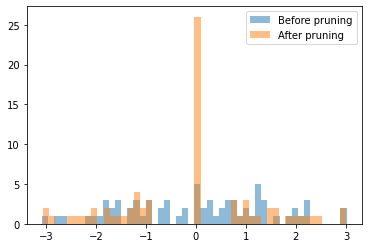

In [32]:
plt.hist(params_before_prune, bins=50, alpha=0.5, label='Before pruning')
plt.hist(params_after_prune, bins=50, alpha=0.5, label='After pruning')
plt.legend()
plt.show()

*pruning ratio* of the parameters are zero after pruning.

Circuit depth: 7
Architecture:


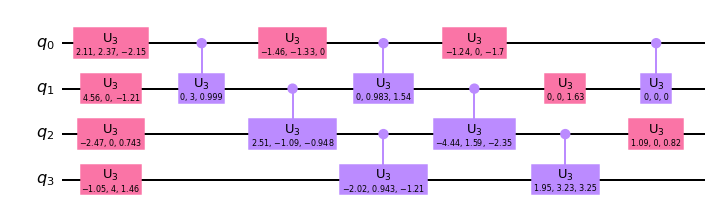

In [33]:
circ = tq2qiskit(tq.QuantumDevice(n_wires=model.n_wires), model2.q_layer)
print("Circuit depth: {0}".format(circ.depth()))
print("Architecture:")
circ.draw('mpl')


###Part 3: Evaluate the best gene on real QC

Evaluate our searched gene with pruned parameters on real quantum computers.

In [34]:
processor_real_qc = QiskitProcessor(use_real_qc=True, noise_model_name = 'ibmq_quito', backend_name='ibmq_quito')

model = model2

model.set_qiskit_processor(processor_real_qc)

evaluate_gene(gene=gene, use_qiskit=True)

ibmqfactory.load_account:WARNING:2022-09-19 00:59:26,608: Credentials are already in use. The existing account in the session will be replaced.

  0%|          | 0/2 [00:00<?, ?it/s][2022-09-19 00:59:29.915] Before transpile: {'depth': 12, 'size': 35, 'width': 8, 'n_single_gates': 24, 'n_two_gates': 7, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 8, 'cu3': 7, 'measure': 4}}
[2022-09-19 00:59:30.004] After transpile: {'depth': 59, 'size': 135, 'width': 9, 'n_single_gates': 119, 'n_two_gates': 12, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 46, 'rz': 73, 'cx': 12, 'measure': 4}}
Process ForkPoolWorker-317:
Process ForkPoolWorker-316:
Process ForkPoolWorker-318:
Process ForkPoolWorker-319:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/multiprocess/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/local

KeyboardInterrupt: ignored